In [1]:
import numpy as np
from tqdm import tqdm
import os
import glob
import re
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import xml.etree.ElementTree as ET
import imgaug as ia
from imgaug import augmenters as iaa
from tqdm import tqdm

In [3]:
import tensorflow as tf
print('Tensorflow version : {}'.format(tf.__version__))
print('GPU : {}'.format(tf.config.list_physical_devices('GPU')))
from tensorflow import keras
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Concatenate, concatenate, Dropout, LeakyReLU, Reshape, Activation, Conv2D, Input, MaxPooling2D, BatchNormalization, Flatten, Dense, Lambda
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        # Select GPU number 1
        tf.config.experimental.set_visible_devices(gpus[3], 'GPU')
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

Tensorflow version : 2.4.1
GPU : [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:3', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:4', device_type='GPU')]
5 Physical GPUs, 1 Logical GPUs


# Parameters
Here are some parameters that we use in the model and others.
* images size : 416x416
* GRID size : 13x13 which is image size divide by 12
* score threshold : 0.5
* IOU threshold : 0.45
* Anchors is calculated by K-means clustering algorthem and follow YOLOv2 paper choose K = 5

In [18]:
# Parameters

LABELS           = ("aeroplane", "bicycle", "bird", "boat", "bottle", 
                 "bus", "car", "cat", "chair", "cow", "diningtable", 
                 "dog", "horse", "motorbike", "person", "pottedplant", 
                 "sheep", "sofa", "train","tvmonitor")
IMAGE_H, IMAGE_W = 416, 416
GRID_H,  GRID_W  = 13, 13 # GRID size = IMAGE size / 32
BOX              = 5 
CLASS            = len(LABELS)
SCORE_THRESHOLD  = 0.5
IOU_THRESHOLD    = 0.45
ANCHORS          = [0.57273, 0.677385, 1.87446, 2.06253, 3.33843, 5.47434, 7.88282, 3.52778, 9.77052, 9.16828]

TRAIN_BATCH_SIZE = 32
VAL_BATCH_SIZE   = 32
EPOCHS           = 200

LAMBDA_NOOBJECT  = 1
LAMBDA_OBJECT    = 5
LAMBDA_CLASS     = 1
LAMBDA_COORD     = 1

MAX_OBJECTS_PER_IMAGE = 30

# Train and Validation directory
* we split the last 10% photos for validation data.

In [4]:
# Train and validation directory

train_image_folder = 'VOCdevkit_train/VOC2007/Augement_image/'
train_annot_folder = 'VOCdevkit_train/VOC2007/Augmentation.txt'
val_image_folder = 'VOCdevkit_valid/VOC2007/JPEGImages/'
val_annot_folder = 'VOCdevkit_valid/VOC2007/pascal_voc_validation_data.txt'

# SpaceToDepth 
* This is a function that will be used in skip-connection.

In [20]:
# Custom Keras layer

class SpaceToDepth(keras.layers.Layer):

    def __init__(self, block_size, **kwargs):
        self.block_size = block_size
        super(SpaceToDepth, self).__init__(**kwargs)

    def call(self, inputs):
        x = inputs
        batch, height, width, depth = K.int_shape(x)
        batch = -1
        reduced_height = height // self.block_size
        reduced_width = width // self.block_size
        y = K.reshape(x, (batch, reduced_height, self.block_size,
                             reduced_width, self.block_size, depth))
        z = K.permute_dimensions(y, (0, 1, 3, 2, 4, 5))
        t = K.reshape(z, (batch, reduced_height, reduced_width, depth * self.block_size **2))
        return t

    def compute_output_shape(self, input_shape):
        shape =  (input_shape[0], input_shape[1] // self.block_size, input_shape[2] // self.block_size,
                  input_shape[3] * self.block_size **2)
        return tf.TensorShape(shape)

# YOLOv2 model
### Adjustments for a better YOLO
* Batch normalization

* Classifying on high resolution inputs
  1. Firstly train the classifier on 224x224 resolution on ImageNet.
  2. Secondly fine tune the classifier on 448x448 resolution for 10 epochs, this make the network’s filters adjust to higher resolution inputs.
  3. Then fine tune the resulting network on detection.

* Convolutional layers with anchor boxes
  1. Most of objects in the training dataset have a vary of sizes, which makes learning process hard.
  2.  Anchor boxes are a set of predefined box shapes selected to match ground truth bounding boxes, so we only need to predicts size of Anchor boxes

*
* Remove the fully connected layer responsible for predicting bounding boxes and replace it with anchor boxes prediction

* Making YOLO faster with Darknet-19

### Architecture
![](https://i.imgur.com/dDBKj0S.png)

In [ ]:
input_image = tf.keras.layers.Input((IMAGE_H, IMAGE_W, 3), dtype='float32')

# Layer 1
x = Conv2D(32, (3,3), strides=(1,1), padding='same', name='conv_1', use_bias=False)(input_image)
x = BatchNormalization(name='norm_1')(x)
x = LeakyReLU(alpha=0.1)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Layer 2
x = Conv2D(64, (3,3), strides=(1,1), padding='same', name='conv_2', use_bias=False)(x)
x = BatchNormalization(name='norm_2')(x)
x = LeakyReLU(alpha=0.1)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Layer 3
x = Conv2D(128, (3,3), strides=(1,1), padding='same', name='conv_3', use_bias=False)(x)
x = BatchNormalization(name='norm_3')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 4
x = Conv2D(64, (1,1), strides=(1,1), padding='same', name='conv_4', use_bias=False)(x)
x = BatchNormalization(name='norm_4')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 5
x = Conv2D(128, (3,3), strides=(1,1), padding='same', name='conv_5', use_bias=False)(x)
x = BatchNormalization(name='norm_5')(x)
x = LeakyReLU(alpha=0.1)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Layer 6
x = Conv2D(256, (3,3), strides=(1,1), padding='same', name='conv_6', use_bias=False)(x)
x = BatchNormalization(name='norm_6')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 7
x = Conv2D(128, (1,1), strides=(1,1), padding='same', name='conv_7', use_bias=False)(x)
x = BatchNormalization(name='norm_7')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 8
x = Conv2D(256, (3,3), strides=(1,1), padding='same', name='conv_8', use_bias=False)(x)
x = BatchNormalization(name='norm_8')(x)
x = LeakyReLU(alpha=0.1)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Layer 9
x = Conv2D(512, (3,3), strides=(1,1), padding='same', name='conv_9', use_bias=False)(x)
x = BatchNormalization(name='norm_9')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 10
x = Conv2D(256, (1,1), strides=(1,1), padding='same', name='conv_10', use_bias=False)(x)
x = BatchNormalization(name='norm_10')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 11
x = Conv2D(512, (3,3), strides=(1,1), padding='same', name='conv_11', use_bias=False)(x)
x = BatchNormalization(name='norm_11')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 12
x = Conv2D(256, (1,1), strides=(1,1), padding='same', name='conv_12', use_bias=False)(x)
x = BatchNormalization(name='norm_12')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 13
x = Conv2D(512, (3,3), strides=(1,1), padding='same', name='conv_13', use_bias=False)(x)
x = BatchNormalization(name='norm_13')(x)
x = LeakyReLU(alpha=0.1)(x)

skip_connection = x

x = MaxPooling2D(pool_size=(2, 2))(x)

# Layer 14
x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_14', use_bias=False)(x)
x = BatchNormalization(name='norm_14')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 15
x = Conv2D(512, (1,1), strides=(1,1), padding='same', name='conv_15', use_bias=False)(x)
x = BatchNormalization(name='norm_15')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 16
x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_16', use_bias=False)(x)
x = BatchNormalization(name='norm_16')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 17
x = Conv2D(512, (1,1), strides=(1,1), padding='same', name='conv_17', use_bias=False)(x)
x = BatchNormalization(name='norm_17')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 18
x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_18', use_bias=False)(x)
x = BatchNormalization(name='norm_18')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 19
x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_19', use_bias=False)(x)
x = BatchNormalization(name='norm_19')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 20
x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_20', use_bias=False)(x)
x = BatchNormalization(name='norm_20')(x)
x = LeakyReLU(alpha=0.1)(x)


# Layer 21
skip_connection = Conv2D(64, (1,1), strides=(1,1), padding='same', name='conv_21', use_bias=False)(skip_connection)
skip_connection = BatchNormalization(name='norm_21')(skip_connection)
skip_connection = LeakyReLU(alpha=0.1)(skip_connection)

skip_connection = SpaceToDepth(block_size=2)(skip_connection)

x = concatenate([skip_connection, x])

# Layer 22
x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_22', use_bias=False)(x)
x = BatchNormalization(name='norm_22')(x)
x = LeakyReLU(alpha=0.1)(x)
x = Dropout(0.3)(x) # add dropout

# Layer 23
x = Conv2D(BOX * (4 + 1 + CLASS), (1,1), strides=(1,1), padding='same', name='conv_23')(x)
output = Reshape((GRID_W, GRID_H, BOX, 4 + 1 + CLASS))(x)

model = keras.models.Model(input_image, output)

# Function of Loading Weights

In [7]:
class WeightReader:
    def __init__(self, weight_file):
        self.offset = 4
        self.all_weights = np.fromfile(weight_file, dtype='float32')
        
    def read_bytes(self, size):
        self.offset = self.offset + size
        return self.all_weights[self.offset-size:self.offset]
    
    def reset(self):
        self.offset = 4

# Load darknet19 weight
* Initially, our yolov2 model can only get map 0.9.
* We load the Darknet pretrain weights for image classification on IMAGENET, and yolv2 can get good performance

![](https://i.imgur.com/WQcQ1A7.png)

In [8]:
weight_reader = WeightReader('darknet19.weights')

In [9]:
weight_reader.reset()
nb_conv = 18

for i in range(1, nb_conv+1):
    conv_layer = model.get_layer('conv_' + str(i))
    conv_layer.trainable = True
    #print(i)
    #print(len(conv_layer.get_weights()))
    
    if i < nb_conv:
        norm_layer = model.get_layer('norm_' + str(i))
        norm_layer.trainable = True
        
        size = np.prod(norm_layer.get_weights()[0].shape)

        beta  = weight_reader.read_bytes(size)
        gamma = weight_reader.read_bytes(size)
        mean  = weight_reader.read_bytes(size)
        var   = weight_reader.read_bytes(size)

        weights = norm_layer.set_weights([gamma, beta, mean, var])       
        
    if len(conv_layer.get_weights()) > 1:
        bias   = weight_reader.read_bytes(np.prod(conv_layer.get_weights()[1].shape))
        kernel = weight_reader.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
        kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
        kernel = kernel.transpose([2,3,1,0])
        conv_layer.set_weights([kernel, bias])
    else:
        kernel = weight_reader.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
        kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
        kernel = kernel.transpose([2,3,1,0])
        conv_layer.set_weights([kernel])

In [10]:
layer   = model.layers[-2] # last convolutional layer
layer.trainable = True


weights = layer.get_weights()

new_kernel = np.random.normal(size=weights[0].shape)/(GRID_H*GRID_W)
new_bias   = np.random.normal(size=weights[1].shape)/(GRID_H*GRID_W)

layer.set_weights([new_kernel, new_bias])

# Generate Dataset

In [ ]:
class DatasetGenerator:
    def __init__(self, dataset='train'):
        self.image_names = []
        self.record_list = []
        self.dataset = dataset
        # filling the record_list
        if dataset=='train':
            input_file = open(train_txt, 'r')
        else:
            input_file = open(val_txt, 'r')


        for line in input_file:
            line = line.strip()
            ss = line.split(' ')
            self.image_names.append(ss[0])
            
            self.record_list.append([float(num) for num in ss[1:]])
            # print(self.record_list)

            if len(self.record_list[-1]) < MAX_OBJECTS_PER_IMAGE*5:
                # if there are objects less than MAX_OBJECTS_PER_IMAGE, pad the list
                self.record_list[-1] = self.record_list[-1] +\
                [0., 0., 0., 0., 0.]*\
                (MAX_OBJECTS_PER_IMAGE-len(self.record_list[-1])//5)
                
            elif len(self.record_list[-1]) > MAX_OBJECTS_PER_IMAGE*5:
               # if there are objects more than MAX_OBJECTS_PER_IMAGE, crop the list
                self.record_list[-1] = self.record_list[-1][:MAX_OBJECTS_PER_IMAGE*5]
                
            self.record_list[-1] = tf.reshape(self.record_list[-1], [30, 5])
        self.record_list = np.asarray(self.record_list)
        print(self.record_list.shape)

    def _data_preprocess(self, image_name, raw_labels, object_num):
        if self.dataset=='train':
            image_file = tf.io.read_file(train_image_folder+image_name)
        else:
            image_file = tf.io.read_file(val_image_folder+image_name)

        # print(IMAGE_DIR+image_name)
        image = tf.io.decode_jpeg(image_file, channels=3)
        image = tf.image.convert_image_dtype(image, tf.float32)

        h = tf.shape(image)[0]
        w = tf.shape(image)[1]

        width_ratio  = IMAGE_W * 1.0 / tf.cast(w, tf.float32) 
        height_ratio = IMAGE_H * 1.0 / tf.cast(h, tf.float32) 

        image = tf.image.resize(image, size=[IMAGE_W, IMAGE_H])
        
        xmin = int(tf.math.round(raw_labels[:, 0]*width_ratio))
        ymin = int(tf.math.round(raw_labels[:, 1]*height_ratio))
        xmax = int(tf.math.round(raw_labels[:, 2]*width_ratio))
        ymax = int(tf.math.round(raw_labels[:, 3]*height_ratio))

        class_num = int(raw_labels[:, 4]+1)

        labels = tf.stack([xmin, ymin, xmax, ymax, class_num], axis=1)

        return image, labels

    def generate(self):
        dataset = tf.data.Dataset.from_tensor_slices((self.image_names, 
                                                      np.array(self.record_list), 
                                                      np.array(self.object_num_list)))
        dataset = dataset.shuffle(100000)
        dataset = dataset.map(self._data_preprocess, num_parallel_calls = tf.data.experimental.AUTOTUNE)
        dataset = dataset.repeat()
        dataset = dataset.batch(BATCH_SIZE, drop_remainder = True)
        dataset = dataset.prefetch(10)

        return dataset

In [ ]:
train_dataset= DatasetGenerator.generate()
val_dataset= DatasetGenerator.generate()

# Fit YOLO format and Generate Anchors boxes

In [57]:
def process_true_boxes(true_boxes, anchors, image_width, image_height):
    
    scale = IMAGE_W / GRID_W # scale = 32
    
    anchors_count = len(anchors) // 2
    anchors = np.array(anchors)
    anchors = anchors.reshape(len(anchors) // 2, 2)
    
    detector_mask = np.zeros((GRID_W, GRID_H, anchors_count, 1))
    matching_true_boxes = np.zeros((GRID_W, GRID_H, anchors_count, 5))
    
    # convert true_boxes numpy array -> tensor
    true_boxes = true_boxes.numpy()
    # print(true_boxes)
    
    true_boxes_grid = np.zeros(true_boxes.shape)
    
    # convert bounding box coords and localize bounding box
    for i, box in enumerate(true_boxes):
        # convert box coords to x, y, w, h and convert to grids coord
        w = (box[2] - box[0]) / scale
        h = (box[3] - box[1]) / scale    
        x = ((box[0] + box[2]) / 2) / scale
        y = ((box[1] + box[3]) / 2) / scale
        true_boxes_grid[i,...] = np.array([x, y, w, h, box[4]])
        if w * h > 0: # box exists
            # calculate iou between box and each anchors and find best anchors
            best_iou = 0
            best_anchor = 0
            for i in range(anchors_count): 
                # iou (anchor and box are shifted to 0,0)
                intersect = np.minimum(w, anchors[i,0]) * np.minimum(h, anchors[i,1])
                union = (anchors[i,0] * anchors[i,1]) + (w * h) - intersect
                iou = intersect / union
                if iou > best_iou:
                    best_iou = iou
                    best_anchor = i
            # localize box in detector_mask and matching true_boxes
            if best_iou > 0:
                # print('yes')
                x_coord = np.floor(x).astype('int')
                y_coord = np.floor(y).astype('int')
                # print(x_coord, y_coord)
                detector_mask[y_coord, x_coord, best_anchor] = 1
                yolo_box = np.array([x, y, w, h, box[4]])
                # print(yolo_box.shape)
                matching_true_boxes[y_coord, x_coord, best_anchor,:] = yolo_box
                # print(y_coord, x_coord, best_anchor)
                # print(matching_true_boxes[y_coord, x_coord, best_anchor,:] )

    return matching_true_boxes, detector_mask, true_boxes_grid

# Grounf Truth Generator
* Ground truth batch generator from a yolo dataset, ready to compare with YOLO prediction in loss function.

In [58]:
def ground_truth_generator(dataset):
    for batch in dataset:
        # imgs
        imgs = batch[0]
        
        # true boxes
        true_boxes = batch[1]
        # print(true_boxes[0])
        
        # matching_true_boxes and detector_mask
        batch_matching_true_boxes = []
        batch_detector_mask = []
        batch_true_boxes_grid = []
        
        for i in range(true_boxes.shape[0]):     
            one_matching_true_boxes, one_detector_mask, true_boxes_grid = process_true_boxes(true_boxes[i],
                                                                                           ANCHORS,
                                                                                           IMAGE_W,
                                                                                           IMAGE_H)
            batch_matching_true_boxes.append(one_matching_true_boxes)
            batch_detector_mask.append(one_detector_mask)
            batch_true_boxes_grid.append(true_boxes_grid)
                
        detector_mask = tf.convert_to_tensor(np.array(batch_detector_mask), dtype='float32')
        matching_true_boxes = tf.convert_to_tensor(np.array(batch_matching_true_boxes), dtype='float32')
        true_boxes_grid = tf.convert_to_tensor(np.array(batch_true_boxes_grid), dtype='float32')
        
        # class one_hot
        matching_classes = K.cast(matching_true_boxes[..., 4], 'int32') 
        # print(matching_classes)
        class_one_hot = K.one_hot(matching_classes, CLASS + 1)[:,:,:,:,1:]
        class_one_hot = tf.cast(class_one_hot, dtype='float32')
        
        batch = (imgs, detector_mask, matching_true_boxes, class_one_hot, true_boxes_grid)
        yield batch

In [59]:
# Ground true generator
train_gen = ground_truth_generator(train_dataset)
val_gen = ground_truth_generator(val_dataset)

In [61]:
def iou(x1, y1, w1, h1, x2, y2, w2, h2):
    xmin1 = x1 - 0.5*w1
    xmax1 = x1 + 0.5*w1
    ymin1 = y1 - 0.5*h1
    ymax1 = y1 + 0.5*h1
    xmin2 = x2 - 0.5*w2
    xmax2 = x2 + 0.5*w2
    ymin2 = y2 - 0.5*h2
    ymax2 = y2 + 0.5*h2
    interx = np.minimum(xmax1, xmax2) - np.maximum(xmin1, xmin2)
    intery = np.minimum(ymax1, ymax2) - np.maximum(ymin1, ymin2)
    inter = interx * intery
    union = w1*h1 + w2*h2 - inter
    iou = inter / (union + 1e-6)
    return iou

# Loss function
* Calculate Loss from prediction and grouth truth tensors.
  * detector_mask: contains batchsize, cell width, cell height, anchor and detecting flag
  * matching_true_boxes: contain coords of bounding box
  * class_one_hot: transfer the bounding box label to number by One hot representation
  * true_boxes_grid: contain coords of ground truth bounding box
  * y_pred: prediction from model


* To calculate loss, the first step is **adjust coordinates** to grid cell unit.  
Next, the second step is calculate the loss, we can simply take a look for yolov2 loss function.

![](https://i.imgur.com/pyeKq2C.png)

* As you can see, there is lots of loss we should calculate.  
* The first loss we calculate is **coordinate loss** which is **xy_loss + wh_loss**.  
* And we implenment the sigma formula to get **xy_loss** and **wh_loss**.  
* Next, we calculate the **class loss** by CrossEntropy function with logits.  
* Furthermore, we calculate IOU and find the **best IOU** between prediction and true_boxes.
* So, we can calculate the **confidence loss** which consist of obj confidence loss , noobj confidence loss, and IOU score.  
* Finally, we get the **total Loss**.  

In [62]:
# loss

def yolov2_loss(detector_mask, matching_true_boxes, class_one_hot, true_boxes_grid, y_pred, info=False):
    # anchors tensor
    anchors = np.array(ANCHORS)
    anchors = anchors.reshape(len(anchors) // 2, 2)
    
    # grid coords tensor
    coord_x = tf.cast(tf.reshape(tf.tile(tf.range(GRID_W), [GRID_H]), (1, GRID_H, GRID_W, 1, 1)), tf.float32)
    coord_y = tf.transpose(coord_x, (0,2,1,3,4))
    coords = tf.tile(tf.concat([coord_x,coord_y], -1), [y_pred.shape[0], 1, 1, 5, 1])
    
    # coordinate loss
    pred_xy = K.sigmoid(y_pred[:,:,:,:,0:2]) # adjust coords between 0 and 1
    pred_xy = (pred_xy + coords) # add cell coord for comparaison with ground truth. New coords in grid cell unit
    pred_wh = K.exp(y_pred[:,:,:,:,2:4]) * anchors # adjust width and height for comparaison with ground truth. New coords in grid cell unit
    #pred_wh = (pred_wh * anchors) # unit : grid cell
    nb_detector_mask = K.sum(tf.cast(detector_mask > 0.0, tf.float32))
    xy_loss = LAMBDA_COORD * K.sum(detector_mask * K.square(matching_true_boxes[...,:2] - pred_xy)) / (nb_detector_mask + 1e-6) # Non /2
    wh_loss = LAMBDA_COORD * K.sum(detector_mask * K.square(K.sqrt(matching_true_boxes[...,2:4]) - 
                                                            K.sqrt(pred_wh))) / (nb_detector_mask + 1e-6)
    coord_loss = xy_loss + wh_loss
    
    # class loss    
    pred_box_class = y_pred[..., 5:]
    true_box_class = tf.argmax(class_one_hot, -1)
    # print(true_box_class)
    # print(pred_box_class)
    #class_loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=true_box_class, logits=pred_box_class)
    class_loss = K.sparse_categorical_crossentropy(target=true_box_class, output=pred_box_class, from_logits=True)
    class_loss = K.expand_dims(class_loss, -1) * detector_mask
    class_loss = LAMBDA_CLASS * K.sum(class_loss) / (nb_detector_mask + 1e-6)
    
    # confidence loss
    pred_conf = K.sigmoid(y_pred[...,4:5])
    # for each detector : iou between prediction and ground truth
    x1 = matching_true_boxes[...,0]
    y1 = matching_true_boxes[...,1]
    w1 = matching_true_boxes[...,2]
    h1 = matching_true_boxes[...,3]
    x2 = pred_xy[...,0]
    y2 = pred_xy[...,1]
    w2 = pred_wh[...,0]
    h2 = pred_wh[...,1]
    ious = iou(x1, y1, w1, h1, x2, y2, w2, h2)
    ious = K.expand_dims(ious, -1)
     
    # for each detector : best ious between prediction and true_boxes (every bounding box of image)
    pred_xy = K.expand_dims(pred_xy, 4) # shape : m, GRID_W, GRID_H, BOX, 1, 2 
    pred_wh = K.expand_dims(pred_wh, 4)
    pred_wh_half = pred_wh / 2.
    pred_mins = pred_xy - pred_wh_half
    pred_maxes = pred_xy + pred_wh_half
    true_boxe_shape = K.int_shape(true_boxes_grid)
    true_boxes_grid = K.reshape(true_boxes_grid, [true_boxe_shape[0], 1, 1, 1, true_boxe_shape[1], true_boxe_shape[2]])
    true_xy = true_boxes_grid[...,0:2]
    true_wh = true_boxes_grid[...,2:4]
    true_wh_half = true_wh * 0.5
    true_mins = true_xy - true_wh_half
    true_maxes = true_xy + true_wh_half
    intersect_mins = K.maximum(pred_mins, true_mins) # shape : m, GRID_W, GRID_H, BOX, MAX_OBJECTS_PER_IMAGE, 2 
    intersect_maxes = K.minimum(pred_maxes, true_maxes) # shape : m, GRID_W, GRID_H, BOX, MAX_OBJECTS_PER_IMAGE, 2
    intersect_wh = K.maximum(intersect_maxes - intersect_mins, 0.) # shape : m, GRID_W, GRID_H, BOX, MAX_OBJECTS_PER_IMAGE, 1
    intersect_areas = intersect_wh[..., 0] * intersect_wh[..., 1] # shape : m, GRID_W, GRID_H, BOX, MAX_OBJECTS_PER_IMAGE, 1
    pred_areas = pred_wh[..., 0] * pred_wh[..., 1] # shape : m, GRID_W, GRID_H, BOX, 1, 1
    true_areas = true_wh[..., 0] * true_wh[..., 1] # shape : m, GRID_W, GRID_H, BOX, MAX_OBJECTS_PER_IMAGE, 1
    union_areas = pred_areas + true_areas - intersect_areas
    iou_scores = intersect_areas / union_areas # shape : m, GRID_W, GRID_H, BOX, MAX_OBJECTS_PER_IMAGE, 1
    best_ious = K.max(iou_scores, axis=4)  # Best IOU scores.
    best_ious = K.expand_dims(best_ious) # shape : m, GRID_W, GRID_H, BOX, 1
    
    # no object confidence loss
    no_object_detection = K.cast(best_ious < 0.6, K.dtype(best_ious)) 
    noobj_mask = no_object_detection * (1 - detector_mask)
    nb_noobj_mask  = K.sum(tf.cast(noobj_mask  > 0.0, tf.float32))
    
    noobject_loss =  LAMBDA_NOOBJECT * K.sum(noobj_mask * K.square(-pred_conf)) / (nb_noobj_mask + 1e-6)
    # object confidence loss
    object_loss = LAMBDA_OBJECT * K.sum(detector_mask * K.square(ious - pred_conf)) / (nb_detector_mask + 1e-6)
    # total confidence loss
    conf_loss = noobject_loss + object_loss
    
    # total loss
    loss = conf_loss + class_loss + coord_loss
    sub_loss = [conf_loss, class_loss, coord_loss]  

    if info:
        print('conf_loss   : {:.4f}'.format(conf_loss))
        print('class_loss  : {:.4f}'.format(class_loss))
        print('coord_loss  : {:.4f}'.format(coord_loss))
        print('    xy_loss : {:.4f}'.format(xy_loss))
        print('    wh_loss : {:.4f}'.format(wh_loss))
        print('--------------------')
        print('total loss  : {:.4f}'.format(loss))
        
        # display masks for each anchors
        for i in range(len(anchors)):
            f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(10, 5))
            f.tight_layout()
            f.suptitle('MASKS FOR ANCHOR {} :'.format(anchors[i,...]))
            
            ax1.matshow((K.sum(detector_mask[0,:,:,i], axis=2)), cmap='Greys', vmin=0, vmax=1)
            ax1.set_title('detector_mask, count : {}'.format(K.sum(tf.cast(detector_mask[0,:,:,i]  > 0., tf.int32))))
            ax1.xaxis.set_ticks_position('bottom')
            
            ax2.matshow((K.sum(no_object_detection[0,:,:,i], axis=2)), cmap='Greys', vmin=0, vmax=1)
            ax2.set_title('no_object_detection mask')
            ax2.xaxis.set_ticks_position('bottom')
            
            ax3.matshow((K.sum(noobj_mask[0,:,:,i], axis=2)), cmap='Greys', vmin=0, vmax=1)
            ax3.set_title('noobj_mask')
            ax3.xaxis.set_ticks_position('bottom')
              
    return loss, sub_loss

# Some sub-training function
* we calculate gradients by **grad** function.  
* To find the best weights, we make a **save_best_weights** function to ensure the best weight will be save.  
and the **log_loss** function is just a tensorboard that can show the process.

In [64]:
# gradients
def grad(model, img, detector_mask, matching_true_boxes, class_one_hot, true_boxes, training=True):
    with tf.GradientTape() as tape:
        y_pred = model(img, training)
        loss, sub_loss = yolov2_loss(detector_mask, matching_true_boxes, class_one_hot, true_boxes, y_pred)
    return loss, sub_loss, tape.gradient(loss, model.trainable_variables)

# save weights
def save_best_weights(model, name, val_loss_avg):
    # delete existing weights file
    files = glob.glob(os.path.join('weights/', name + '*'))
    for file in files:
        os.remove(file)
    # create new weights file
    name = name + '_' + str(val_loss_avg) + '.h5'
    path_name = os.path.join('weights/', name)
    model.save_weights(path_name)

# log (tensorboard)
def log_loss(loss, val_loss, step):
    tf.summary.scalar('loss', loss, step)
    tf.summary.scalar('val_loss', val_loss, step)

# Training
* we train the whole YOLO model for 200 epochs and learning rate is 0.00001.  
* Both training dataset and validation dataset have same hyperparameter.

In [65]:
# training
def train(epochs, model, train_dataset, val_dataset, steps_per_epoch_train, steps_per_epoch_val, train_name = 'train'):
    num_epochs = epochs
    steps_per_epoch_train = steps_per_epoch_train
    steps_per_epoch_val = steps_per_epoch_val
    train_loss_history = []
    val_loss_history = []
    best_val_loss = 1e6
    
    # optimizer
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    
    # log (tensorboard)
    summary_writer = tf.summary.create_file_writer(os.path.join('logs/', train_name), flush_millis=20000)
    summary_writer.set_as_default()
    
    # training
    for epoch in range(num_epochs):
        epoch_loss = []
        epoch_val_loss = []
        epoch_val_sub_loss = []
        print('Epoch {} :'.format(epoch))
        # train
        for batch_idx in tqdm(range(steps_per_epoch_train)): 
            img, detector_mask, matching_true_boxes, class_one_hot, true_boxes =  next(train_dataset)
            loss, _, grads = grad(model, img, detector_mask, matching_true_boxes, class_one_hot, true_boxes)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))
            epoch_loss.append(loss)
            # print('-', end='')
        # print(' | ', end='')
        # val
        for batch_idx in range(steps_per_epoch_val): 
            img, detector_mask, matching_true_boxes, class_one_hot, true_boxes =  next(val_dataset)
            loss, sub_loss, grads = grad(model, img, detector_mask, matching_true_boxes, class_one_hot, true_boxes, training=False)
            epoch_val_loss.append(loss)
            epoch_val_sub_loss.append(sub_loss)
            # print('-', end='')

        loss_avg = np.mean(np.array(epoch_loss))
        val_loss_avg = np.mean(np.array(epoch_val_loss))
        sub_loss_avg = np.mean(np.array(epoch_val_sub_loss), axis=0)
        train_loss_history.append(loss_avg)
        val_loss_history.append(val_loss_avg)
        
        # log
        log_loss(loss_avg, val_loss_avg, epoch)
        
        # save
        if val_loss_avg < best_val_loss:
            save_best_weights(model, train_name, val_loss_avg)
            best_val_loss = val_loss_avg
        
        print(' loss = {:.4f}, val_loss = {:.4f} (conf={:.4f}, class={:.4f}, coords={:.4f})'.format(
            loss_avg, val_loss_avg, sub_loss_avg[0], sub_loss_avg[1], sub_loss_avg[2]))
        
    return [train_loss_history, val_loss_history]

Epoch 0 :


100%|██████████| 20/20 [00:05<00:00,  3.79it/s]


 loss = 3.8368, val_loss = 3.7784 (conf=0.4311, class=2.9879, coords=0.3594)
Epoch 1 :


100%|██████████| 20/20 [00:04<00:00,  4.92it/s]


 loss = 3.7494, val_loss = 3.8356 (conf=0.4410, class=2.9803, coords=0.4142)
Epoch 2 :


100%|██████████| 20/20 [00:04<00:00,  4.95it/s]


 loss = 3.6285, val_loss = 3.7429 (conf=0.4151, class=2.9601, coords=0.3677)
Epoch 3 :


100%|██████████| 20/20 [00:04<00:00,  4.88it/s]


 loss = 3.5516, val_loss = 3.7986 (conf=0.4358, class=2.9483, coords=0.4146)
Epoch 4 :


100%|██████████| 20/20 [00:04<00:00,  4.98it/s]


 loss = 3.4397, val_loss = 3.6649 (conf=0.4049, class=2.8931, coords=0.3669)
Epoch 5 :


100%|██████████| 20/20 [00:04<00:00,  5.00it/s]


 loss = 3.3272, val_loss = 3.6307 (conf=0.3910, class=2.8638, coords=0.3760)
Epoch 6 :


100%|██████████| 20/20 [00:04<00:00,  4.96it/s]


 loss = 3.2668, val_loss = 3.5884 (conf=0.4019, class=2.8058, coords=0.3807)
Epoch 7 :


100%|██████████| 20/20 [00:04<00:00,  4.93it/s]


 loss = 3.0894, val_loss = 3.5054 (conf=0.4166, class=2.7233, coords=0.3655)
Epoch 8 :


100%|██████████| 20/20 [00:04<00:00,  4.91it/s]


 loss = 3.0123, val_loss = 3.3855 (conf=0.3923, class=2.6553, coords=0.3379)
Epoch 9 :


100%|██████████| 20/20 [00:03<00:00,  5.01it/s]


 loss = 2.9679, val_loss = 3.2417 (conf=0.3635, class=2.5298, coords=0.3484)
Epoch 10 :


100%|██████████| 20/20 [00:03<00:00,  5.04it/s]


 loss = 2.9027, val_loss = 3.0738 (conf=0.3583, class=2.3927, coords=0.3228)
Epoch 11 :


100%|██████████| 20/20 [00:03<00:00,  5.01it/s]


 loss = 2.8108, val_loss = 3.0334 (conf=0.3783, class=2.3032, coords=0.3519)
Epoch 12 :


100%|██████████| 20/20 [00:03<00:00,  5.03it/s]


 loss = 2.7311, val_loss = 2.9078 (conf=0.3489, class=2.1575, coords=0.4014)
Epoch 13 :


100%|██████████| 20/20 [00:03<00:00,  5.06it/s]


 loss = 2.6851, val_loss = 2.7587 (conf=0.3473, class=2.0605, coords=0.3509)
Epoch 14 :


100%|██████████| 20/20 [00:04<00:00,  4.96it/s]


 loss = 2.5769, val_loss = 2.8531 (conf=0.3471, class=2.1768, coords=0.3292)
Epoch 15 :


100%|██████████| 20/20 [00:04<00:00,  4.86it/s]


 loss = 2.5605, val_loss = 2.5026 (conf=0.3110, class=1.8396, coords=0.3521)
Epoch 16 :


100%|██████████| 20/20 [00:04<00:00,  4.93it/s]


 loss = 2.5346, val_loss = 2.5014 (conf=0.3173, class=1.7815, coords=0.4026)
Epoch 17 :


100%|██████████| 20/20 [00:04<00:00,  4.97it/s]


 loss = 2.4457, val_loss = 2.6133 (conf=0.3265, class=1.9409, coords=0.3458)
Epoch 18 :


100%|██████████| 20/20 [00:04<00:00,  4.98it/s]


 loss = 2.4116, val_loss = 2.2429 (conf=0.3086, class=1.6141, coords=0.3203)
Epoch 19 :


100%|██████████| 20/20 [00:04<00:00,  4.95it/s]


 loss = 2.3476, val_loss = 2.2600 (conf=0.3029, class=1.6346, coords=0.3225)
Epoch 20 :


100%|██████████| 20/20 [00:04<00:00,  4.93it/s]


 loss = 2.3527, val_loss = 2.0102 (conf=0.3092, class=1.3686, coords=0.3325)
Epoch 21 :


100%|██████████| 20/20 [00:04<00:00,  4.96it/s]


 loss = 2.2599, val_loss = 2.1493 (conf=0.2748, class=1.5202, coords=0.3544)
Epoch 22 :


100%|██████████| 20/20 [00:04<00:00,  4.91it/s]


 loss = 2.1986, val_loss = 2.0264 (conf=0.2966, class=1.4271, coords=0.3026)
Epoch 23 :


100%|██████████| 20/20 [00:04<00:00,  4.98it/s]


 loss = 2.2610, val_loss = 2.1001 (conf=0.2916, class=1.4826, coords=0.3259)
Epoch 24 :


100%|██████████| 20/20 [00:04<00:00,  5.00it/s]


 loss = 2.1116, val_loss = 1.9217 (conf=0.2669, class=1.2887, coords=0.3661)
Epoch 25 :


100%|██████████| 20/20 [00:04<00:00,  5.00it/s]


 loss = 2.1363, val_loss = 1.8618 (conf=0.2805, class=1.2521, coords=0.3292)
Epoch 26 :


100%|██████████| 20/20 [00:03<00:00,  5.01it/s]


 loss = 2.1209, val_loss = 1.8072 (conf=0.2992, class=1.2018, coords=0.3062)
Epoch 27 :


100%|██████████| 20/20 [00:03<00:00,  5.01it/s]


 loss = 2.0432, val_loss = 2.0345 (conf=0.2774, class=1.4177, coords=0.3394)
Epoch 28 :


100%|██████████| 20/20 [00:04<00:00,  4.97it/s]


 loss = 2.0145, val_loss = 1.9742 (conf=0.2859, class=1.3264, coords=0.3619)
Epoch 29 :


100%|██████████| 20/20 [00:04<00:00,  4.87it/s]


 loss = 1.9412, val_loss = 1.5275 (conf=0.2573, class=0.9549, coords=0.3152)
Epoch 30 :


100%|██████████| 20/20 [00:04<00:00,  4.76it/s]


 loss = 1.9597, val_loss = 1.6647 (conf=0.2636, class=1.0428, coords=0.3583)
Epoch 31 :


100%|██████████| 20/20 [00:04<00:00,  4.98it/s]


 loss = 1.9604, val_loss = 1.5487 (conf=0.2642, class=0.9523, coords=0.3322)
Epoch 32 :


100%|██████████| 20/20 [00:03<00:00,  5.02it/s]


 loss = 1.9139, val_loss = 1.6878 (conf=0.2733, class=1.1035, coords=0.3111)
Epoch 33 :


100%|██████████| 20/20 [00:04<00:00,  4.96it/s]


 loss = 1.8003, val_loss = 1.8450 (conf=0.2578, class=1.2312, coords=0.3561)
Epoch 34 :


100%|██████████| 20/20 [00:04<00:00,  4.99it/s]


 loss = 1.8895, val_loss = 1.6824 (conf=0.2676, class=1.1269, coords=0.2879)
Epoch 35 :


100%|██████████| 20/20 [00:04<00:00,  4.97it/s]


 loss = 1.8056, val_loss = 1.6344 (conf=0.2527, class=1.0408, coords=0.3409)
Epoch 36 :


100%|██████████| 20/20 [00:04<00:00,  4.96it/s]


 loss = 1.7576, val_loss = 1.4942 (conf=0.2747, class=0.8947, coords=0.3248)
Epoch 37 :


100%|██████████| 20/20 [00:04<00:00,  4.91it/s]


 loss = 1.6761, val_loss = 1.7041 (conf=0.2853, class=1.0874, coords=0.3314)
Epoch 38 :


100%|██████████| 20/20 [00:04<00:00,  4.96it/s]


 loss = 1.7471, val_loss = 1.5992 (conf=0.2478, class=1.0203, coords=0.3311)
Epoch 39 :


100%|██████████| 20/20 [00:04<00:00,  4.97it/s]


 loss = 1.7303, val_loss = 1.6236 (conf=0.2649, class=1.0129, coords=0.3458)
Epoch 40 :


100%|██████████| 20/20 [00:04<00:00,  4.92it/s]


 loss = 1.6881, val_loss = 1.6049 (conf=0.2506, class=1.0316, coords=0.3227)
Epoch 41 :


100%|██████████| 20/20 [00:04<00:00,  4.96it/s]


 loss = 1.6909, val_loss = 1.4574 (conf=0.2662, class=0.9032, coords=0.2880)
Epoch 42 :


100%|██████████| 20/20 [00:04<00:00,  4.98it/s]


 loss = 1.6065, val_loss = 1.4735 (conf=0.2472, class=0.9311, coords=0.2952)
Epoch 43 :


100%|██████████| 20/20 [00:04<00:00,  4.97it/s]


 loss = 1.6004, val_loss = 1.5375 (conf=0.2463, class=0.9505, coords=0.3407)
Epoch 44 :


100%|██████████| 20/20 [00:04<00:00,  4.87it/s]


 loss = 1.5987, val_loss = 1.6214 (conf=0.2594, class=1.0685, coords=0.2935)
Epoch 45 :


100%|██████████| 20/20 [00:04<00:00,  4.92it/s]


 loss = 1.5556, val_loss = 1.4227 (conf=0.2505, class=0.8457, coords=0.3266)
Epoch 46 :


100%|██████████| 20/20 [00:04<00:00,  4.97it/s]


 loss = 1.6350, val_loss = 1.5368 (conf=0.2835, class=0.9408, coords=0.3125)
Epoch 47 :


100%|██████████| 20/20 [00:04<00:00,  4.95it/s]


 loss = 1.5355, val_loss = 1.2455 (conf=0.2264, class=0.6951, coords=0.3240)
Epoch 48 :


100%|██████████| 20/20 [00:03<00:00,  5.05it/s]


 loss = 1.5786, val_loss = 1.6352 (conf=0.2378, class=1.0999, coords=0.2976)
Epoch 49 :


100%|██████████| 20/20 [00:03<00:00,  5.00it/s]


 loss = 1.4713, val_loss = 1.3885 (conf=0.2454, class=0.8117, coords=0.3314)
Epoch 50 :


100%|██████████| 20/20 [00:03<00:00,  5.00it/s]


 loss = 1.4176, val_loss = 1.3901 (conf=0.2491, class=0.8180, coords=0.3229)
Epoch 51 :


100%|██████████| 20/20 [00:04<00:00,  4.87it/s]


 loss = 1.4708, val_loss = 1.6144 (conf=0.2624, class=1.0529, coords=0.2991)
Epoch 52 :


100%|██████████| 20/20 [00:04<00:00,  4.97it/s]


 loss = 1.5084, val_loss = 1.4919 (conf=0.2417, class=0.9500, coords=0.3003)
Epoch 53 :


100%|██████████| 20/20 [00:03<00:00,  5.00it/s]


 loss = 1.4085, val_loss = 1.2659 (conf=0.2604, class=0.6986, coords=0.3070)
Epoch 54 :


100%|██████████| 20/20 [00:04<00:00,  4.95it/s]


 loss = 1.4351, val_loss = 1.4479 (conf=0.2264, class=0.8751, coords=0.3464)
Epoch 55 :


100%|██████████| 20/20 [00:04<00:00,  4.94it/s]


 loss = 1.4178, val_loss = 1.6540 (conf=0.2269, class=1.0779, coords=0.3492)
Epoch 56 :


100%|██████████| 20/20 [00:04<00:00,  4.99it/s]


 loss = 1.4109, val_loss = 1.2130 (conf=0.2358, class=0.6789, coords=0.2983)
Epoch 57 :


100%|██████████| 20/20 [00:04<00:00,  4.96it/s]


 loss = 1.3616, val_loss = 1.4247 (conf=0.2402, class=0.8982, coords=0.2863)
Epoch 58 :


100%|██████████| 20/20 [00:04<00:00,  4.88it/s]


 loss = 1.3770, val_loss = 1.2742 (conf=0.2491, class=0.7644, coords=0.2608)
Epoch 59 :


100%|██████████| 20/20 [00:03<00:00,  5.01it/s]


 loss = 1.3993, val_loss = 1.2588 (conf=0.2518, class=0.7116, coords=0.2954)
Epoch 60 :


100%|██████████| 20/20 [00:04<00:00,  4.88it/s]


 loss = 1.3474, val_loss = 1.3291 (conf=0.2420, class=0.7907, coords=0.2964)
Epoch 61 :


100%|██████████| 20/20 [00:04<00:00,  4.91it/s]


 loss = 1.3435, val_loss = 1.2169 (conf=0.2704, class=0.6514, coords=0.2951)
Epoch 62 :


100%|██████████| 20/20 [00:04<00:00,  4.88it/s]


 loss = 1.3142, val_loss = 1.2373 (conf=0.2208, class=0.7113, coords=0.3052)
Epoch 63 :


100%|██████████| 20/20 [00:04<00:00,  4.75it/s]


 loss = 1.2985, val_loss = 1.4469 (conf=0.2273, class=0.9228, coords=0.2968)
Epoch 64 :


100%|██████████| 20/20 [00:04<00:00,  4.90it/s]


 loss = 1.2991, val_loss = 1.2389 (conf=0.2404, class=0.7000, coords=0.2985)
Epoch 65 :


100%|██████████| 20/20 [00:04<00:00,  4.90it/s]


 loss = 1.2578, val_loss = 1.3976 (conf=0.2707, class=0.8169, coords=0.3100)
Epoch 66 :


100%|██████████| 20/20 [00:04<00:00,  4.79it/s]


 loss = 1.2877, val_loss = 1.1315 (conf=0.2260, class=0.6237, coords=0.2819)
Epoch 67 :


100%|██████████| 20/20 [00:04<00:00,  4.86it/s]


 loss = 1.2652, val_loss = 1.2142 (conf=0.2272, class=0.6884, coords=0.2986)
Epoch 68 :


100%|██████████| 20/20 [00:04<00:00,  4.88it/s]


 loss = 1.2597, val_loss = 1.4237 (conf=0.2279, class=0.8637, coords=0.3322)
Epoch 69 :


100%|██████████| 20/20 [00:04<00:00,  4.91it/s]


 loss = 1.2559, val_loss = 1.5875 (conf=0.2309, class=1.0708, coords=0.2859)
Epoch 70 :


100%|██████████| 20/20 [00:04<00:00,  4.88it/s]


 loss = 1.2272, val_loss = 1.3030 (conf=0.2063, class=0.7959, coords=0.3008)
Epoch 71 :


100%|██████████| 20/20 [00:04<00:00,  4.93it/s]


 loss = 1.2194, val_loss = 1.2155 (conf=0.2178, class=0.6883, coords=0.3094)
Epoch 72 :


100%|██████████| 20/20 [00:04<00:00,  4.91it/s]


 loss = 1.2037, val_loss = 1.2763 (conf=0.2364, class=0.7107, coords=0.3291)
Epoch 73 :


100%|██████████| 20/20 [00:04<00:00,  4.84it/s]


 loss = 1.2180, val_loss = 1.2830 (conf=0.2217, class=0.7586, coords=0.3027)
Epoch 74 :


100%|██████████| 20/20 [00:04<00:00,  4.91it/s]


 loss = 1.1747, val_loss = 1.1522 (conf=0.2410, class=0.6130, coords=0.2983)
Epoch 75 :


100%|██████████| 20/20 [00:04<00:00,  4.90it/s]


 loss = 1.1499, val_loss = 1.0671 (conf=0.2281, class=0.5577, coords=0.2813)
Epoch 76 :


100%|██████████| 20/20 [00:04<00:00,  4.94it/s]


 loss = 1.1584, val_loss = 1.3791 (conf=0.2380, class=0.8426, coords=0.2986)
Epoch 77 :


100%|██████████| 20/20 [00:04<00:00,  4.93it/s]


 loss = 1.1456, val_loss = 1.1426 (conf=0.2292, class=0.5891, coords=0.3243)
Epoch 78 :


100%|██████████| 20/20 [00:04<00:00,  4.93it/s]


 loss = 1.1238, val_loss = 1.1586 (conf=0.2125, class=0.6439, coords=0.3022)
Epoch 79 :


100%|██████████| 20/20 [00:04<00:00,  4.87it/s]


 loss = 1.1197, val_loss = 1.2696 (conf=0.2304, class=0.7647, coords=0.2746)
Epoch 80 :


100%|██████████| 20/20 [00:04<00:00,  4.87it/s]


 loss = 1.1281, val_loss = 1.3577 (conf=0.2480, class=0.7840, coords=0.3257)
Epoch 81 :


100%|██████████| 20/20 [00:04<00:00,  4.97it/s]


 loss = 1.1150, val_loss = 1.3531 (conf=0.2369, class=0.8502, coords=0.2660)
Epoch 82 :


100%|██████████| 20/20 [00:04<00:00,  4.91it/s]


 loss = 1.1099, val_loss = 1.1449 (conf=0.2207, class=0.6312, coords=0.2930)
Epoch 83 :


100%|██████████| 20/20 [00:04<00:00,  4.93it/s]


 loss = 1.0812, val_loss = 1.1788 (conf=0.2057, class=0.6739, coords=0.2992)
Epoch 84 :


100%|██████████| 20/20 [00:04<00:00,  4.90it/s]


 loss = 1.0771, val_loss = 1.3418 (conf=0.2305, class=0.8101, coords=0.3013)
Epoch 85 :


100%|██████████| 20/20 [00:04<00:00,  4.93it/s]


 loss = 1.1018, val_loss = 1.3001 (conf=0.2412, class=0.7480, coords=0.3108)
Epoch 86 :


100%|██████████| 20/20 [00:04<00:00,  4.90it/s]


 loss = 1.0319, val_loss = 1.3356 (conf=0.2217, class=0.8483, coords=0.2656)
Epoch 87 :


100%|██████████| 20/20 [00:04<00:00,  4.88it/s]


 loss = 1.0498, val_loss = 1.1667 (conf=0.2126, class=0.6462, coords=0.3079)
Epoch 88 :


100%|██████████| 20/20 [00:04<00:00,  4.97it/s]


 loss = 1.0401, val_loss = 1.1898 (conf=0.2159, class=0.6923, coords=0.2816)
Epoch 89 :


100%|██████████| 20/20 [00:04<00:00,  4.94it/s]


 loss = 1.0351, val_loss = 1.3187 (conf=0.2342, class=0.7803, coords=0.3042)
Epoch 90 :


100%|██████████| 20/20 [00:04<00:00,  4.97it/s]


 loss = 1.0353, val_loss = 1.2771 (conf=0.2230, class=0.7339, coords=0.3202)
Epoch 91 :


100%|██████████| 20/20 [00:04<00:00,  4.94it/s]


 loss = 1.0302, val_loss = 1.2316 (conf=0.2272, class=0.7122, coords=0.2922)
Epoch 92 :


100%|██████████| 20/20 [00:04<00:00,  4.89it/s]


 loss = 1.0291, val_loss = 1.0529 (conf=0.2333, class=0.5178, coords=0.3017)
Epoch 93 :


100%|██████████| 20/20 [00:04<00:00,  4.91it/s]


 loss = 1.0175, val_loss = 1.0708 (conf=0.2361, class=0.5807, coords=0.2541)
Epoch 94 :


100%|██████████| 20/20 [00:04<00:00,  4.65it/s]


 loss = 0.9873, val_loss = 1.1635 (conf=0.2256, class=0.6506, coords=0.2872)
Epoch 95 :


100%|██████████| 20/20 [00:04<00:00,  4.81it/s]


 loss = 1.0361, val_loss = 1.2605 (conf=0.1646, class=0.8038, coords=0.2921)
Epoch 96 :


100%|██████████| 20/20 [00:04<00:00,  4.93it/s]


 loss = 0.9641, val_loss = 1.2134 (conf=0.2154, class=0.7235, coords=0.2745)
Epoch 97 :


100%|██████████| 20/20 [00:04<00:00,  4.87it/s]


 loss = 0.9847, val_loss = 1.2208 (conf=0.2151, class=0.7047, coords=0.3011)
Epoch 98 :


100%|██████████| 20/20 [00:04<00:00,  4.84it/s]


 loss = 0.9511, val_loss = 1.1529 (conf=0.2026, class=0.6380, coords=0.3123)
Epoch 99 :


100%|██████████| 20/20 [00:04<00:00,  4.87it/s]


 loss = 0.8995, val_loss = 1.0644 (conf=0.2065, class=0.5671, coords=0.2907)
Epoch 100 :


100%|██████████| 20/20 [00:04<00:00,  4.92it/s]


 loss = 0.9418, val_loss = 1.2132 (conf=0.2231, class=0.7032, coords=0.2869)
Epoch 101 :


100%|██████████| 20/20 [00:04<00:00,  4.82it/s]


 loss = 0.9420, val_loss = 1.3044 (conf=0.2108, class=0.7643, coords=0.3294)
Epoch 102 :


100%|██████████| 20/20 [00:04<00:00,  4.86it/s]


 loss = 0.9828, val_loss = 1.0541 (conf=0.2091, class=0.5498, coords=0.2952)
Epoch 103 :


100%|██████████| 20/20 [00:04<00:00,  4.87it/s]


 loss = 0.9414, val_loss = 1.1522 (conf=0.1909, class=0.6703, coords=0.2909)
Epoch 104 :


100%|██████████| 20/20 [00:04<00:00,  4.84it/s]


 loss = 0.9483, val_loss = 1.1203 (conf=0.2272, class=0.6211, coords=0.2720)
Epoch 105 :


100%|██████████| 20/20 [00:04<00:00,  4.86it/s]


 loss = 0.9493, val_loss = 1.3238 (conf=0.2001, class=0.8343, coords=0.2894)
Epoch 106 :


100%|██████████| 20/20 [00:04<00:00,  4.91it/s]


 loss = 0.8748, val_loss = 1.0916 (conf=0.1923, class=0.6209, coords=0.2784)
Epoch 107 :


100%|██████████| 20/20 [00:04<00:00,  4.90it/s]


 loss = 0.8911, val_loss = 1.1124 (conf=0.2064, class=0.6234, coords=0.2826)
Epoch 108 :


100%|██████████| 20/20 [00:04<00:00,  4.83it/s]


 loss = 0.9068, val_loss = 1.2198 (conf=0.2148, class=0.7306, coords=0.2744)
Epoch 109 :


100%|██████████| 20/20 [00:04<00:00,  4.93it/s]


 loss = 0.8979, val_loss = 1.2720 (conf=0.2002, class=0.7672, coords=0.3047)
Epoch 110 :


100%|██████████| 20/20 [00:04<00:00,  4.94it/s]


 loss = 0.9042, val_loss = 1.0951 (conf=0.2073, class=0.6074, coords=0.2804)
Epoch 111 :


100%|██████████| 20/20 [00:04<00:00,  4.90it/s]


 loss = 0.8644, val_loss = 1.2597 (conf=0.1978, class=0.7736, coords=0.2883)
Epoch 112 :


100%|██████████| 20/20 [00:04<00:00,  4.88it/s]


 loss = 0.8940, val_loss = 1.2907 (conf=0.2176, class=0.7876, coords=0.2854)
Epoch 113 :


100%|██████████| 20/20 [00:04<00:00,  4.93it/s]


 loss = 0.8551, val_loss = 1.0768 (conf=0.2060, class=0.5540, coords=0.3169)
Epoch 114 :


100%|██████████| 20/20 [00:04<00:00,  4.89it/s]


 loss = 0.8561, val_loss = 0.9527 (conf=0.2004, class=0.4690, coords=0.2834)
Epoch 115 :


100%|██████████| 20/20 [00:04<00:00,  4.89it/s]


 loss = 0.8543, val_loss = 0.9976 (conf=0.2019, class=0.5066, coords=0.2891)
Epoch 116 :


100%|██████████| 20/20 [00:04<00:00,  4.77it/s]


 loss = 0.8402, val_loss = 1.3471 (conf=0.2050, class=0.8680, coords=0.2741)
Epoch 117 :


100%|██████████| 20/20 [00:04<00:00,  4.91it/s]


 loss = 0.8251, val_loss = 1.0798 (conf=0.1922, class=0.6184, coords=0.2691)
Epoch 118 :


100%|██████████| 20/20 [00:04<00:00,  4.87it/s]


 loss = 0.8773, val_loss = 1.0542 (conf=0.1986, class=0.5379, coords=0.3177)
Epoch 119 :


100%|██████████| 20/20 [00:04<00:00,  4.91it/s]


 loss = 0.8707, val_loss = 1.0901 (conf=0.2034, class=0.6211, coords=0.2657)
Epoch 120 :


100%|██████████| 20/20 [00:04<00:00,  4.93it/s]


 loss = 0.8078, val_loss = 1.1887 (conf=0.1857, class=0.6933, coords=0.3097)
Epoch 121 :


100%|██████████| 20/20 [00:04<00:00,  4.90it/s]


 loss = 0.8329, val_loss = 1.1647 (conf=0.1997, class=0.6702, coords=0.2948)
Epoch 122 :


100%|██████████| 20/20 [00:03<00:00,  5.01it/s]


 loss = 0.8075, val_loss = 0.9946 (conf=0.2158, class=0.5046, coords=0.2742)
Epoch 123 :


100%|██████████| 20/20 [00:04<00:00,  4.91it/s]


 loss = 0.8090, val_loss = 1.2325 (conf=0.1910, class=0.7325, coords=0.3090)
Epoch 124 :


100%|██████████| 20/20 [00:04<00:00,  4.94it/s]


 loss = 0.7787, val_loss = 1.2702 (conf=0.2021, class=0.7748, coords=0.2933)
Epoch 125 :


100%|██████████| 20/20 [00:04<00:00,  4.82it/s]


 loss = 0.8030, val_loss = 1.1451 (conf=0.1927, class=0.6553, coords=0.2971)
Epoch 126 :


100%|██████████| 20/20 [00:04<00:00,  5.00it/s]


 loss = 0.8263, val_loss = 1.0142 (conf=0.1905, class=0.5458, coords=0.2779)
Epoch 127 :


100%|██████████| 20/20 [00:03<00:00,  5.00it/s]


 loss = 0.7723, val_loss = 1.0305 (conf=0.1953, class=0.5572, coords=0.2781)
Epoch 128 :


100%|██████████| 20/20 [00:04<00:00,  4.98it/s]


 loss = 0.7897, val_loss = 1.2011 (conf=0.1843, class=0.7135, coords=0.3032)
Epoch 129 :


100%|██████████| 20/20 [00:04<00:00,  4.96it/s]


 loss = 0.7713, val_loss = 1.1388 (conf=0.2018, class=0.6560, coords=0.2811)
Epoch 130 :


100%|██████████| 20/20 [00:04<00:00,  4.92it/s]


 loss = 0.7813, val_loss = 1.0731 (conf=0.1979, class=0.6008, coords=0.2744)
Epoch 131 :


100%|██████████| 20/20 [00:04<00:00,  4.96it/s]


 loss = 0.7431, val_loss = 1.3519 (conf=0.1960, class=0.8850, coords=0.2709)
Epoch 132 :


100%|██████████| 20/20 [00:04<00:00,  5.00it/s]


 loss = 0.7838, val_loss = 1.1766 (conf=0.1927, class=0.6913, coords=0.2926)
Epoch 133 :


100%|██████████| 20/20 [00:04<00:00,  4.96it/s]


 loss = 0.8010, val_loss = 1.0144 (conf=0.1971, class=0.5636, coords=0.2536)
Epoch 134 :


100%|██████████| 20/20 [00:04<00:00,  4.95it/s]


 loss = 0.7111, val_loss = 1.0876 (conf=0.1925, class=0.5760, coords=0.3191)
Epoch 135 :


100%|██████████| 20/20 [00:04<00:00,  4.96it/s]


 loss = 0.7203, val_loss = 1.3003 (conf=0.1937, class=0.8250, coords=0.2816)
Epoch 136 :


100%|██████████| 20/20 [00:04<00:00,  4.99it/s]


 loss = 0.7496, val_loss = 1.1406 (conf=0.1951, class=0.6706, coords=0.2749)
Epoch 137 :


100%|██████████| 20/20 [00:04<00:00,  4.86it/s]


 loss = 0.7402, val_loss = 0.9492 (conf=0.2033, class=0.4708, coords=0.2750)
Epoch 138 :


100%|██████████| 20/20 [00:04<00:00,  4.96it/s]


 loss = 0.7497, val_loss = 1.1422 (conf=0.2079, class=0.6783, coords=0.2560)
Epoch 139 :


100%|██████████| 20/20 [00:04<00:00,  4.98it/s]


 loss = 0.7417, val_loss = 1.1694 (conf=0.1846, class=0.6850, coords=0.2999)
Epoch 140 :


100%|██████████| 20/20 [00:04<00:00,  4.96it/s]


 loss = 0.7631, val_loss = 1.0882 (conf=0.2068, class=0.6172, coords=0.2642)
Epoch 141 :


100%|██████████| 20/20 [00:04<00:00,  4.94it/s]


 loss = 0.7305, val_loss = 1.3697 (conf=0.2056, class=0.8546, coords=0.3095)
Epoch 142 :


100%|██████████| 20/20 [00:04<00:00,  4.95it/s]


 loss = 0.7173, val_loss = 1.0116 (conf=0.1850, class=0.5447, coords=0.2819)
Epoch 143 :


100%|██████████| 20/20 [00:04<00:00,  4.96it/s]


 loss = 0.7103, val_loss = 1.1416 (conf=0.1943, class=0.6708, coords=0.2764)
Epoch 144 :


100%|██████████| 20/20 [00:04<00:00,  4.88it/s]


 loss = 0.7167, val_loss = 1.0233 (conf=0.2024, class=0.5570, coords=0.2639)
Epoch 145 :


100%|██████████| 20/20 [00:04<00:00,  4.82it/s]


 loss = 0.7073, val_loss = 0.9026 (conf=0.1528, class=0.4666, coords=0.2832)
Epoch 146 :


100%|██████████| 20/20 [00:04<00:00,  4.85it/s]


 loss = 0.7122, val_loss = 1.2149 (conf=0.1985, class=0.7252, coords=0.2912)
Epoch 147 :


100%|██████████| 20/20 [00:04<00:00,  4.90it/s]


 loss = 0.6843, val_loss = 1.2179 (conf=0.1962, class=0.7377, coords=0.2840)
Epoch 148 :


100%|██████████| 20/20 [00:04<00:00,  4.92it/s]


 loss = 0.6844, val_loss = 1.2150 (conf=0.2084, class=0.6950, coords=0.3116)
Epoch 149 :


100%|██████████| 20/20 [00:04<00:00,  4.86it/s]


 loss = 0.7032, val_loss = 1.1835 (conf=0.1973, class=0.7092, coords=0.2770)
Epoch 150 :


100%|██████████| 20/20 [00:04<00:00,  4.91it/s]


 loss = 0.6598, val_loss = 0.9765 (conf=0.1801, class=0.5263, coords=0.2701)
Epoch 151 :


100%|██████████| 20/20 [00:04<00:00,  4.90it/s]


 loss = 0.6506, val_loss = 1.0366 (conf=0.1719, class=0.6210, coords=0.2437)
Epoch 152 :


100%|██████████| 20/20 [00:04<00:00,  4.84it/s]


 loss = 0.6744, val_loss = 0.9588 (conf=0.2026, class=0.4951, coords=0.2611)
Epoch 153 :


100%|██████████| 20/20 [00:04<00:00,  4.94it/s]


 loss = 0.6606, val_loss = 0.9475 (conf=0.1774, class=0.4998, coords=0.2703)
Epoch 154 :


100%|██████████| 20/20 [00:04<00:00,  4.88it/s]


 loss = 0.6714, val_loss = 1.2377 (conf=0.2026, class=0.7539, coords=0.2812)
Epoch 155 :


100%|██████████| 20/20 [00:04<00:00,  4.89it/s]


 loss = 0.6553, val_loss = 1.3324 (conf=0.1928, class=0.7943, coords=0.3453)
Epoch 156 :


100%|██████████| 20/20 [00:04<00:00,  4.90it/s]


 loss = 0.6718, val_loss = 1.0637 (conf=0.2019, class=0.6074, coords=0.2545)
Epoch 157 :


100%|██████████| 20/20 [00:04<00:00,  4.90it/s]


 loss = 0.6514, val_loss = 0.9481 (conf=0.1672, class=0.5047, coords=0.2762)
Epoch 158 :


100%|██████████| 20/20 [00:04<00:00,  4.70it/s]


 loss = 0.6425, val_loss = 1.0016 (conf=0.1774, class=0.5607, coords=0.2635)
Epoch 159 :


100%|██████████| 20/20 [00:04<00:00,  4.79it/s]


 loss = 0.6620, val_loss = 1.0673 (conf=0.1938, class=0.5891, coords=0.2844)
Epoch 160 :


100%|██████████| 20/20 [00:04<00:00,  4.84it/s]


 loss = 0.6380, val_loss = 1.0426 (conf=0.1769, class=0.5877, coords=0.2779)
Epoch 161 :


100%|██████████| 20/20 [00:04<00:00,  4.90it/s]


 loss = 0.6504, val_loss = 1.0281 (conf=0.1928, class=0.5493, coords=0.2860)
Epoch 162 :


100%|██████████| 20/20 [00:04<00:00,  4.91it/s]


 loss = 0.6038, val_loss = 1.0620 (conf=0.1965, class=0.6121, coords=0.2535)
Epoch 163 :


100%|██████████| 20/20 [00:04<00:00,  4.92it/s]


 loss = 0.6317, val_loss = 1.0843 (conf=0.1705, class=0.6323, coords=0.2815)
Epoch 164 :


100%|██████████| 20/20 [00:04<00:00,  4.96it/s]


 loss = 0.6173, val_loss = 1.3516 (conf=0.1983, class=0.8883, coords=0.2650)
Epoch 165 :


100%|██████████| 20/20 [00:04<00:00,  4.89it/s]


 loss = 0.6255, val_loss = 1.1278 (conf=0.1720, class=0.6942, coords=0.2615)
Epoch 166 :


100%|██████████| 20/20 [00:04<00:00,  4.88it/s]


 loss = 0.6189, val_loss = 0.9494 (conf=0.1749, class=0.5051, coords=0.2693)
Epoch 167 :


100%|██████████| 20/20 [00:04<00:00,  4.88it/s]


 loss = 0.6244, val_loss = 1.1803 (conf=0.1726, class=0.7241, coords=0.2836)
Epoch 168 :


100%|██████████| 20/20 [00:04<00:00,  4.92it/s]


 loss = 0.6566, val_loss = 1.0616 (conf=0.1803, class=0.6017, coords=0.2796)
Epoch 169 :


100%|██████████| 20/20 [00:04<00:00,  4.91it/s]


 loss = 0.6258, val_loss = 0.9585 (conf=0.2085, class=0.4641, coords=0.2859)
Epoch 170 :


100%|██████████| 20/20 [00:04<00:00,  4.91it/s]


 loss = 0.6062, val_loss = 0.8204 (conf=0.1829, class=0.3663, coords=0.2712)
Epoch 171 :


100%|██████████| 20/20 [00:04<00:00,  4.93it/s]


 loss = 0.5928, val_loss = 0.9019 (conf=0.1814, class=0.4553, coords=0.2652)
Epoch 172 :


100%|██████████| 20/20 [00:04<00:00,  4.93it/s]


 loss = 0.5958, val_loss = 0.9872 (conf=0.1798, class=0.5240, coords=0.2835)
Epoch 173 :


100%|██████████| 20/20 [00:04<00:00,  4.85it/s]


 loss = 0.6192, val_loss = 1.2593 (conf=0.2113, class=0.7811, coords=0.2668)
Epoch 174 :


100%|██████████| 20/20 [00:04<00:00,  4.96it/s]


 loss = 0.6089, val_loss = 1.1874 (conf=0.1695, class=0.7645, coords=0.2534)
Epoch 175 :


100%|██████████| 20/20 [00:04<00:00,  4.91it/s]


 loss = 0.5944, val_loss = 1.2350 (conf=0.1883, class=0.7642, coords=0.2824)
Epoch 176 :


100%|██████████| 20/20 [00:04<00:00,  4.90it/s]


 loss = 0.5962, val_loss = 1.1391 (conf=0.1839, class=0.6891, coords=0.2661)
Epoch 177 :


100%|██████████| 20/20 [00:04<00:00,  4.91it/s]


 loss = 0.5827, val_loss = 0.9769 (conf=0.1769, class=0.5027, coords=0.2973)
Epoch 178 :


100%|██████████| 20/20 [00:04<00:00,  4.93it/s]


 loss = 0.5890, val_loss = 0.9823 (conf=0.1739, class=0.5336, coords=0.2749)
Epoch 179 :


100%|██████████| 20/20 [00:04<00:00,  4.95it/s]


 loss = 0.5679, val_loss = 0.9907 (conf=0.1764, class=0.5447, coords=0.2697)
Epoch 180 :


100%|██████████| 20/20 [00:04<00:00,  4.95it/s]


 loss = 0.5786, val_loss = 1.3475 (conf=0.1899, class=0.8688, coords=0.2888)
Epoch 181 :


100%|██████████| 20/20 [00:04<00:00,  4.87it/s]


 loss = 0.5666, val_loss = 1.2708 (conf=0.1651, class=0.8196, coords=0.2861)
Epoch 182 :


100%|██████████| 20/20 [00:04<00:00,  4.94it/s]


 loss = 0.5824, val_loss = 1.1284 (conf=0.1801, class=0.6677, coords=0.2806)
Epoch 183 :


100%|██████████| 20/20 [00:04<00:00,  4.98it/s]


 loss = 0.5662, val_loss = 1.0370 (conf=0.1937, class=0.5808, coords=0.2625)
Epoch 184 :


100%|██████████| 20/20 [00:04<00:00,  4.99it/s]


 loss = 0.5675, val_loss = 0.7915 (conf=0.1757, class=0.3396, coords=0.2761)
Epoch 185 :


100%|██████████| 20/20 [00:04<00:00,  4.96it/s]


 loss = 0.5594, val_loss = 1.0716 (conf=0.1767, class=0.6308, coords=0.2641)
Epoch 186 :


100%|██████████| 20/20 [00:04<00:00,  4.96it/s]


 loss = 0.5662, val_loss = 1.0886 (conf=0.1919, class=0.5916, coords=0.3051)
Epoch 187 :


100%|██████████| 20/20 [00:04<00:00,  4.99it/s]


 loss = 0.5510, val_loss = 0.9823 (conf=0.2006, class=0.5105, coords=0.2712)
Epoch 188 :


100%|██████████| 20/20 [00:04<00:00,  4.91it/s]


 loss = 0.5622, val_loss = 1.2252 (conf=0.1856, class=0.7350, coords=0.3047)
Epoch 189 :


100%|██████████| 20/20 [00:04<00:00,  4.96it/s]


 loss = 0.5579, val_loss = 1.0198 (conf=0.1604, class=0.6061, coords=0.2533)
Epoch 190 :


100%|██████████| 20/20 [00:04<00:00,  4.99it/s]


 loss = 0.5669, val_loss = 1.1017 (conf=0.2043, class=0.6041, coords=0.2933)
Epoch 191 :


100%|██████████| 20/20 [00:04<00:00,  4.80it/s]


 loss = 0.5459, val_loss = 1.0268 (conf=0.1615, class=0.6183, coords=0.2470)
Epoch 192 :


100%|██████████| 20/20 [00:04<00:00,  4.96it/s]


 loss = 0.5659, val_loss = 1.0928 (conf=0.1699, class=0.6557, coords=0.2671)
Epoch 193 :


100%|██████████| 20/20 [00:04<00:00,  4.91it/s]


 loss = 0.5435, val_loss = 1.3415 (conf=0.1977, class=0.8717, coords=0.2720)
Epoch 194 :


100%|██████████| 20/20 [00:04<00:00,  4.88it/s]


 loss = 0.5503, val_loss = 1.0963 (conf=0.1944, class=0.6041, coords=0.2978)
Epoch 195 :


100%|██████████| 20/20 [00:04<00:00,  4.81it/s]


 loss = 0.5563, val_loss = 1.2989 (conf=0.1947, class=0.8315, coords=0.2727)
Epoch 196 :


100%|██████████| 20/20 [00:04<00:00,  4.84it/s]


 loss = 0.5687, val_loss = 1.0659 (conf=0.1698, class=0.6206, coords=0.2755)
Epoch 197 :


100%|██████████| 20/20 [00:04<00:00,  4.88it/s]


 loss = 0.5296, val_loss = 0.9333 (conf=0.1847, class=0.5092, coords=0.2395)
Epoch 198 :


100%|██████████| 20/20 [00:04<00:00,  4.91it/s]


 loss = 0.5174, val_loss = 1.0007 (conf=0.1726, class=0.5597, coords=0.2685)
Epoch 199 :


100%|██████████| 20/20 [00:04<00:00,  4.90it/s]


 loss = 0.5399, val_loss = 0.8349 (conf=0.1563, class=0.4279, coords=0.2507)


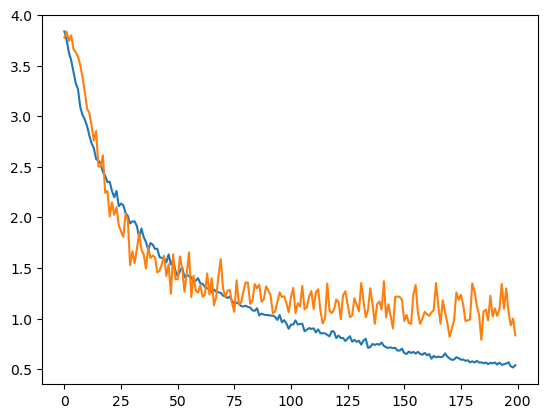

In [66]:
results = train(EPOCHS, model, train_gen, val_gen, 20, 2, 'training_5')

plt.plot(results[0])
plt.plot(results[1])

# Predict test data

In [92]:
def process_output(y_pred, score_threshold, iou_threshold):
    # post prediction process
    # grid coords tensor
    coord_x = tf.cast(tf.reshape(tf.tile(tf.range(GRID_W), [GRID_H]), (1, GRID_H, GRID_W, 1, 1)), tf.float32)
    coord_y = tf.transpose(coord_x, (0,2,1,3,4))
    coords = tf.tile(tf.concat([coord_x,coord_y], -1), [TRAIN_BATCH_SIZE, 1, 1, 5, 1])
    dims = K.cast_to_floatx(K.int_shape(y_pred)[1:3])
    dims = K.reshape(dims,(1,1,1,1,2))
    # anchors tensor
    anchors = np.array(ANCHORS)
    anchors = anchors.reshape(len(anchors) // 2, 2)
    # pred_xy and pred_wh shape (m, GRID_W, GRID_H, Anchors, 2)
    pred_xy = K.sigmoid(y_pred[:,:,:,:,0:2])
    pred_xy = (pred_xy + coords)
    pred_xy = pred_xy / dims
    pred_wh = K.exp(y_pred[:,:,:,:,2:4])
    pred_wh = (pred_wh * anchors)
    pred_wh = pred_wh / dims
    # pred_confidence
    box_conf = K.sigmoid(y_pred[:,:,:,:,4:5])  
    # pred_class
    box_class_prob = K.softmax(y_pred[:,:,:,:,5:])

    # Reshape
    pred_xy = pred_xy[0,...]
    pred_wh = pred_wh[0,...]
    box_conf = box_conf[0,...]
    box_class_prob = box_class_prob[0,...]

    # Convert box coords from x,y,w,h to x1,y1,x2,y2
    box_xy1 = pred_xy - 0.5 * pred_wh
    box_xy2 = pred_xy + 0.5 * pred_wh
    boxes = K.concatenate((box_xy1, box_xy2), axis=-1)

    # Filter boxes
    box_scores = box_conf * box_class_prob
    box_classes = K.argmax(box_scores, axis=-1) # best score index
    # print(box_classes)
    box_class_scores = K.max(box_scores, axis=-1) # best score
    prediction_mask = box_class_scores >= score_threshold
    boxes = tf.boolean_mask(boxes, prediction_mask)
    scores = tf.boolean_mask(box_class_scores, prediction_mask)
    classes = tf.boolean_mask(box_classes, prediction_mask)

    # Scale box to image shape
    boxes = boxes * IMAGE_H

    # Non Max Supression
    selected_idx = tf.image.non_max_suppression(boxes, scores, 50, iou_threshold=iou_threshold)
    boxes = K.gather(boxes, selected_idx)
    scores = K.gather(scores, selected_idx)
    classes = K.gather(classes, selected_idx)
    
    count_detected = boxes.shape[0]

    xmins = []
    ymins = []
    xmaxs = []
    ymaxs = []
    class_nums = []
    confs = []
    for i in range(count_detected):
        # print(i)
        box = boxes[i,...]

        xmins.append(int(tf.math.round(box[0])))
        ymins.append(int(tf.math.round(box[1])))
        xmaxs.append(int(tf.math.round(box[2])))
        ymaxs.append(int(tf.math.round(box[3])))
        class_nums.append(classes[i].numpy())
        confs.append(scores[i].numpy())

    return xmins, ymins, xmaxs, ymaxs, class_nums, confs

In [49]:
model_n = keras.models.Model(input_image, output)
model_n.load_weights('weights/training_2_2.4375658.h5')

In [104]:
test_img_files = open('./pascal_voc_testing_data.txt')
test_img_dir = './VOCdevkit_test/VOC2007/JPEGImages/'
test_images = []

for line in test_img_files:
    line = line.strip()
    ss = line.split(' ')
    test_images.append(ss[0])

test_dataset = tf.data.Dataset.from_tensor_slices(test_images)

def load_img_data(image_name):
    image_file = tf.io.read_file(test_img_dir+image_name)
    image = tf.image.decode_jpeg(image_file, channels=3)

    h = tf.shape(image)[0]
    w = tf.shape(image)[1]

    image = tf.image.resize(image, size=[IMAGE_H, IMAGE_W])
    image = image/255.
    

    return image_name, image, h, w

test_dataset = test_dataset.map(load_img_data, num_parallel_calls = tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(32)

In [ ]:
output_file = open('./test_prediction.txt', 'w')

for img_name, test_img, img_h, img_w in test_dataset:
    batch_num = img_name.shape[0]
    for i in range(batch_num):
        input_image = np.expand_dims(test_img[i], 0)
        y_pred = model.predict_on_batch(input_image)

        xmin, ymin, xmax, ymax, class_num, conf = process_output(y_pred,0.35,0.15)
        # print(len(xmin))
        string = ""
        for j in range(len(xmin)):
          xmin[j], ymin[j], xmax[j], ymax[j] = xmin[j]*(img_w[i:i+1]/IMAGE_H), ymin[j]*(img_h[i:i+1]/IMAGE_W), xmax[j]*(img_w[i:i+1]/IMAGE_H), ymax[j]*(img_h[i:i+1]/IMAGE_W)
          string = string + (" %d %d %d %d %d %f" %(xmin[j], ymin[j], xmax[j], ymax[j], class_num[j], conf[j]))
        #output_file.write(img_name[i:i+1].numpy()[0].decode('ascii')+" %d %d %d %d %d %f\n" %(xmin, ymin, xmax, ymax, class_num, conf))
        output_file.write(img_name[i:i+1].numpy()[0].decode('ascii')+string+"\n")

output_file.close()

In [118]:
import sys
sys.path.insert(0, './evaluate')

In [119]:
import evaluate
#evaluate.evaluate("input prediction file name", "desire output csv file name")
evaluate.evaluate('./test_prediction.txt', './output_file.csv')

End Evalutation
